# Quickstart: `epitope_aligner`

`epitope_aligner` is for manipulating epitope coordinates and sequences so you can analyse  eptiopes from different but aligned sequences. In this demo we'll use IEDB epitopes from several different Influenza virus Hemagglutinin sequences. We'll get the location of the epitopes in an alignment of the antigen sequences, add the epitopes to that alignment, and plot the location and density of epitopes across the alignment both in total and per antigen sequence.

Since these are epitopes from IEDB the epitopes use a 1-index and do include the end position. So several functions will use the arguments `index=1` and `includeend=True`. For more detail on this see the [coordinate system](cookbook.html#Coordinate-system) section of the [cookbook](cookbook.html).

In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib import cm
import requests
import re

import epitope_aligner.map
import epitope_aligner.stretch
import epitope_aligner.utils

Download example files (generated by examples/prepare_iedb_example.py). You may have to install `requests` before you can download the example files. Or you can visit the urls and manually download the files.

In [ ]:
files = ["epitopes.csv", "antigens_al.fa"]
for file in files:
    r = requests.get(f"https://raw.githubusercontent.com/BarinthusBio/epitope_aligner/main/examples/{file}")
    with open(f"../examples/{file}", "w") as f:
        f.write(r.text)

Load the aligned antigen sequences and create a dictionary with accession numbers as keys and sequences as values.

In [2]:
seqs = list(SeqIO.parse("../examples/antigens_al.fa", "fasta"))

# Create dictionary of sequences with accession numbers as keys.
aligned_parent_seqs = {}
for r in seqs:
    aligned_parent_seqs[r.id] = r


# Align coordinates
Load the epitope table and calculate the start and end positions in the aligned version of the parent sequence. Because the epitopes are from different parent sequences `epitope_aligner` needs to know which sequence to use for each epitope. This is why we use the `parent_col` argument to say which column contains the parent sequence names, and those names are used to look up a specific sequence in the dictionary passed to `aligned_parent_seq`.

This can be a bit confusing so it's worth explaining again.
The value `"ACQ76318"` in the "antigen_acc" column tells us to use
`aligned_parent_seqs["ACQ76318"]` to get the parent sequence for that epitope. `epitope_aligner` only knows which column to use because of the `parent_col` argument, and it only knows which dictionary to check for sequences because of the `aligned_parent_seq` argument.

In [3]:

epitopes = pd.read_csv("../examples/epitopes.csv")

epitopes['al_start'] = epitope_aligner.map.align_coords(
    table = epitopes,
    aligned_parent_seq = aligned_parent_seqs,
    index=1,
    coord_col="start",
    parent_col="antigen_acc"
)
epitopes['al_end'] = epitope_aligner.map.align_coords(
    table = epitopes,
    aligned_parent_seq = aligned_parent_seqs,
    index=1,
    coord_col="end",
    parent_col="antigen_acc"
)

epitopes = epitopes.sort_values("al_start")
epitopes

,antigen_acc,linear_sequence,start,end,length,al_start,al_end
449,ACQ76318,MKAILVVLLYTFATAN,1,16,16,4,31
410,ACQ76318,MKAILVVLLYTFATANADTL,1,20,20,4,35
391,ACV41482,MTIIFLILM,1,9,9,4,15
360,ABW90125,MEKIVLLFAIVSLVKSDQ,1,18,18,4,34
277,CAC86622,MKAKLLVLLCTFTATYAD,1,18,18,4,33
...,...,...,...,...,...,...,...
201,ABF21272,SLGAISFWMCSNGSLQ,545,560,16,576,592
116,AAP34324,SLGAISFWMCSNGSLQ,545,560,16,576,592
404,AAB29091,GAISFWMCSNGSLQC,548,562,15,578,593
220,AAZ79974,FIMWACQKGNIRCNICI,550,566,17,580,597


# Float epitopes
Now we know where the epitopes start in the alignment we can write them as an aligned sequence. `float_epitopes()` add gaps to the start of the epitope so it lines up with the supplied parent sequence and it respects gaps within the epitope location too.

We'll save out the aligned antigen and epitope sequences as a fasta file for you to inspect.

In [4]:
epitopes['float'] = epitope_aligner.map.float_epitopes(
    table = epitopes,
    parent_seq = aligned_parent_seqs,
    start_col = "al_start",
    seq_col = "linear_sequence",
    parent_col = "antigen_acc",
    index = 1
)

In [5]:
# Save out epitopes and their source sequences as alignment
epitope_seqs = epitopes.apply(lambda x: f">epi-{x.antigen_acc}\n{x.float}\n", axis=1)
with open("../examples/antigen_epitope_alignment.fa", "w") as f:
    for r in seqs:
        f.write(f">{r.id}\n{r.seq}\n")
        antigen_mask = epitopes.antigen_acc.apply(lambda x: x in r.id)
        f.writelines(epitope_seqs[antigen_mask].tolist())
        

It's always important to manually inspect you alignment files. But we can also create a score to indicate how well the epitope matches a given sequence. Here we calculate the epitopes aligned to the same specific reference. The score is the proportion of non-gap matches between the epitope and parent sequence.

Next we'll calculate a score for each epitope and it's own parent sequence. While a low score against the reference sequence could indicate evolutionary divergen between the parent sequences, a low score to its own parent sequence *may* indicate an issue. This issue could be poor alignment (double check you have the correct `index` and `includeend`), or simply modifications to the epitope sequence.

In [6]:
reference_sequence = "P03452"
reference_sequence = aligned_parent_seqs[reference_sequence]
epitopes[['reference_antigen_score','reference_antigen_matches']] = epitope_aligner.map.score_epitope_alignments(
    table = epitopes,
    parent_seq = reference_sequence.seq,
    seq_col = "float",
)

In [7]:
epitopes[['source_antigen_score','source_antigen_matches']] = epitope_aligner.map.score_epitope_alignments(
    table = epitopes,
    parent_seq = aligned_parent_seqs,
    seq_col = "float",
    parent_col = "antigen_acc"
)
epitopes.head()

,antigen_acc,linear_sequence,start,end,length,al_start,al_end,float,reference_antigen_score,reference_antigen_matches,source_antigen_score,source_antigen_matches
449,ACQ76318,MKAILVVLLYTFATAN,1,16,16,4,31,---MK-AILVVLLYTFAT-----------AN,0.562500,"[True, True, True, False, True, False, True, T...",1.0,"[True, True, True, True, True, True, True, Tru..."
410,ACQ76318,MKAILVVLLYTFATANADTL,1,20,20,4,35,---MK-AILVVLLYTFAT-----------ANADTL,0.600000,"[True, True, True, False, True, False, True, T...",1.0,"[True, True, True, True, True, True, True, Tru..."
391,ACV41482,MTIIFLILM,1,9,9,4,15,---MT---IIFLILM,0.222222,"[True, False, False, False, False, True, False...",1.0,"[True, True, True, True, True, True, True, Tru..."
360,ABW90125,MEKIVLLFAIVSLVKSDQ,1,18,18,4,34,---ME--KIVLLFAIVSL-----------VKSDQ,0.166667,"[True, False, False, False, False, False, True...",1.0,"[True, True, True, True, True, True, True, Tru..."
277,CAC86622,MKAKLLVLLCTFTATYAD,1,18,18,4,33,---MK-AKLLVLLCTFTA-----------TYAD,0.666667,"[True, True, True, False, True, True, True, Tr...",1.0,"[True, True, True, True, True, True, True, Tru..."


# Stretch epitopes
Next we'll calculate the number of epitopes at each position in the antigen alignment. To do this we need to `stretch` the epitopes, this takes a record for each epitope and converts it to a record for each position in each epitope. Then we can count how many epitopes there are at each position using `pandas` `groupby`.
You could also do more complicated oporations on your data in this form, see the [epitope grids](cookbook.html#Epitope-grids) section of the [cookbook](cookbook.html).

Before plotting this count data we also add 0 for any positions with no epitopes.


In [8]:
stretched_epitopes = epitope_aligner.stretch.stretch(
    epitopes,
    length_col="length",
    start_col="al_start",
    seq_col="linear_sequence"
)

positional_count = stretched_epitopes.groupby("position").size()

positional_count = epitope_aligner.stretch.add_empty_positions(
    series=positional_count,
    parent_seq_length=len(reference_sequence),
    index=1,
    empty_value=0
)

As well as counting all epitopes in the alignment you can also count epitopes per parent sequence. You do this by passing two grouping arguments to `groupby`. To get this into a nice format to work with and plot we use `stretch.make_grid()` which reshapes the data into a grid and automatically adds the positions with no epitopes.

If you had MHC data for these epitopes this is a good way to analyse epitopes recognised by each MHCs separately.

In [9]:
antigen_position_count = stretched_epitopes.groupby(["antigen_acc", "position"]).size()
grid = epitope_aligner.stretch.make_grid(
    grid_values = antigen_position_count,
    index=1,
    parent_seq_length = len(reference_sequence),
    empty_value=0
)
grid

0                                      ...                      \
position    1   2   3   4   5   6   7   8   9   10   ... 598 599 600 601 602   
antigen_acc                                          ...                       
ABH01004      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
P03435        0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
1101228B      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
AAA43143      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
AGB08328      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
...          ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..   
P12589        0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
AAP34324      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
NP_859037     0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
AAZ79974      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
ACQ76318      0   0   0   2   2   2   2   2   2   2  ...   0   0   0   0   0   

                                 
position    603 604 605 606 607  
antigen_acc                      
ABH01004      0   0   0   0   0  
P03435        0   0   0   0   0  
1101228B      0   0   0   0   0  
AAA43143      0   0   0   0   0  
AGB08328      0   0   0   0   0  
...          ..  ..  ..  ..  ..  
P12589        0   0   0   0   0  
AAP34324      0   0   0   0   0  
NP_859037     0   0   0   0   0  
AAZ79974      0   0   0   0   0  
ACQ76318      0   0   0   0   0  

[91 rows x 607 columns]

# Plot epitope data
Now we can start plotting our epitope data. The top panel shows the location of epitopes on the x-axis, how well they match the reference sequence on the y-axis, and each epitope is coloured by their parent sequence. It's made using `epitope_aligner.utils.plot_line()` which takes a dataframe of epitopes, and column names for the start, end, and y value.

The second panel shows the total number of epitopes at each position in the antigen alignment.

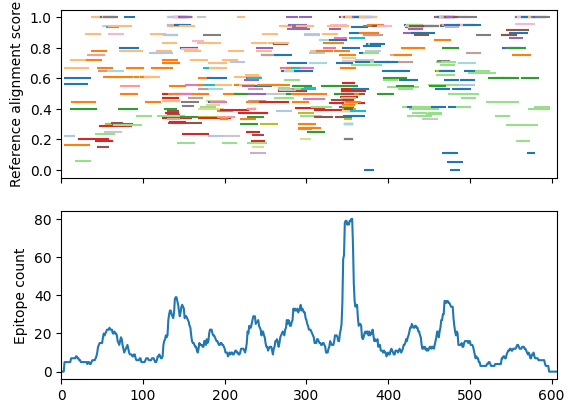

In [10]:
# Create a column of colour values
category_colours = {mhc: cm.tab20(i%20) for i,mhc in enumerate(epitopes.antigen_acc.unique())}
epitopes['color'] = [category_colours[category] for category in epitopes.antigen_acc]

fig, ax = plt.subplots(2, sharex=True)
epitope_aligner.utils.plot_line(
    table=epitopes,
    start_col="al_start",
    end_col="al_end",
    y="reference_antigen_score",
    color_col="color",
    ax=ax[0]
)
ax[0].set_xlim(0, len(reference_sequence))
ax[0].set_ylabel("Reference alignment score")

ax[1].plot(positional_count)
ax[1].set_ylabel("Epitope count")
plt.show()

One benefit of `stretch.make_grid` is that it makes is very easy to plot the data as a heat map. This plot uses colour to show the number of epitopes in a specific parent sequence (y-axis) at a given location (x-axis).

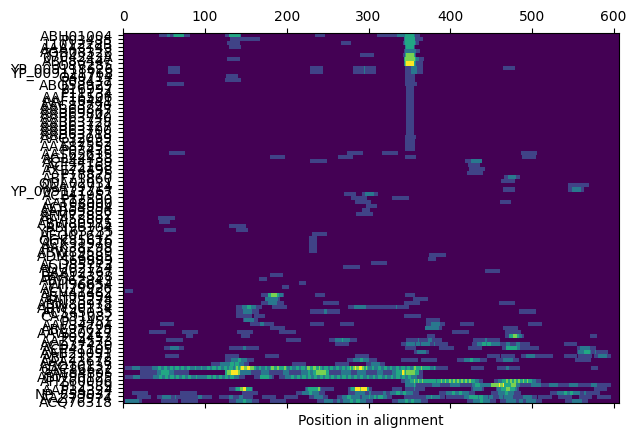

In [11]:
fig,ax = plt.subplots()
ax.matshow(grid, aspect="auto")
ax.set_yticks(np.arange(len(grid.index)), labels=grid.index)
ax.set_xlabel("Position in alignment")
plt.show()

# Conclusion
For more detail on all the functions and uses of `epitope_aligner` checkout the [cookbook](cookbook.html) which goes through all of the functions with examples. Or check out the api in the docs.

If you have any problems or suggestions, please open an [issue](https://github.com/BarinthusBio/epitope_aligner/issues) on github!